## Vesuvius Challenge - Ink Detection Training Notebook

### Setup

In [1]:
# # Pretrained weights
# # ref - https://github.com/kenshohara/3D-ResNets-PyTorch
# !pip install gdown
# !gdown 1Nb4abvIkkp_ydPFA9sNPT1WakoVKA8Fa

# # Utility packages for reading and visualizing volumes
# !pip install zarr imageio-ffmpeg

# save model checkpoints
!mkdir ./ckpts

In [2]:
import os
import gc
import sys
import zarr
import random
import imageio
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Video

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader

sys.path.append("./resnet3d")
from resnet3d import generate_model

### Config

In [3]:
LR = 1e-4
EPOCHS = 50
BATCH_SIZE = 32
CROP_SIZE = 768
Z_START = 24
Z_DIMS = 16
TRAIN_FRAGMENTS = ["1", "2", "3"]
TEST_FRAGMENT = "1"

### Load data

In [4]:


FRAGMENTS_ZARR = {
    "1" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-1.zarr", mode="r"),
    "2" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-2.zarr", mode="r"),
    "3" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-3.zarr", mode="r")
}

FRAGMENTS_SHAPE = {k : v.mask.shape for k, v in FRAGMENTS_ZARR.items()}

### Visualise input

In [5]:
fragment = FRAGMENTS_ZARR["1"]
x, y = 2000, 2000

fragment_cropped = fragment.surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, Z_START:Z_START+Z_DIMS]
imageio.mimwrite("fragment_crop.mp4", fragment_cropped.transpose(2, 0, 1), "ffmpeg")
Video("fragment_crop.mp4", height=256, width=256)

Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. C

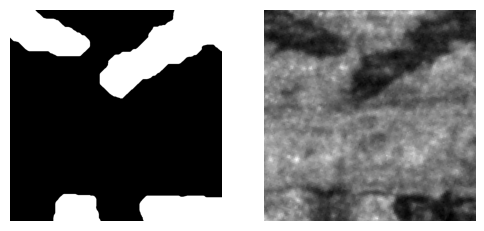

In [6]:
mask_cropped = fragment.truth[y:y+CROP_SIZE, x:x+CROP_SIZE]
ir_cropped = fragment.infrared[y:y+CROP_SIZE, x:x+CROP_SIZE]

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(mask_cropped, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ir_cropped, cmap="gray")
plt.axis("off")
plt.show()

In [7]:
del fragment, fragment_cropped, mask_cropped, ir_cropped
gc.collect()

4083

### Dataloaders

In [8]:
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# class VesuviusTrain(Dataset):
#     def __init__(self, fragments):
#         self.fragments = fragments
#         self.xys = []
        
#         for fragment in fragments:
#             H, W = FRAGMENTS_SHAPE[fragment]
#             for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
#                 for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
#                     self.xys.append((fragment, x, y, W, H))
        
#         train_aug_list = [
#                 # A.RandomResizedCrop(
#                 #     size, size, scale=(0.85, 1.0)),
#                 A.HorizontalFlip(p=0.5),
#                 A.VerticalFlip(p=0.5),
#                 A.RandomBrightnessContrast(p=0.75),
#                 A.CoarseDropout(max_holes=1, max_width=int(CROP_SIZE * 0.1), max_height=int(size * 0.1), 
#                                 mask_fill_value=0, p=0.5),
#                 A.ShiftScaleRotate(p=0.75),
#                 A.Rotate(limit=90, p=0.9), 
#                 A.OneOf([
#                         A.GaussNoise(var_limit=[10, 50]),
#                         A.GaussianBlur(),
#                         A.MotionBlur(),
#                         ], p=0.4),
#                 A.GridDistortion(num_steps=1, distort_limit=0.3, p=0.5),
                
#                 A.Cutout(max_h_size=int(size * 0.6),
#                          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
#                 A.Normalize(
#                     mean= [0] * Z_DIMS,
#                     std= [1] * Z_DIMS
#                 ),
#                 ToTensorV2(transpose_mask=True),
#             ]
        
        
        
#     def __getitem__(self, i):
#         fragment, x1, y1, W, H = self.xys[i]
#         z1, z2 = Z_START, Z_START+Z_DIMS
        
#         x_offset = random.randint(-32 if x1 != 0 else 0, 32)
#         y_offset = random.randint(-32 if y1 != 0 else 0, 32)
        
#         x1 += x_offset
#         y1 += y_offset
        
#         x2 = x1 + CROP_SIZE
#         y2 = y1 + CROP_SIZE
        
#         if x2 > W:
#             x1 -= x_offset
#             x2 -= x_offset
            
#         if y2 > H:
#             y1 -= y_offset
#             y2 -= y_offset
        
#         frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
#         mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
#         if random.random() > 0.5:
#             frag_crop = np.flip(frag_crop, axis=1).copy()
#             mask_crop = np.flip(mask_crop, axis=1).copy()

#         frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
#         frag_crop = frag_crop/65535.0
#         frag_crop = (frag_crop - 0.45)/0.225
        
#         mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        
        
        
        
        
        
        
        
#         return frag_crop, mask_crop

#     def __len__(self):
#         return len(self.xys)

In [45]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class VesuviusTrain(Dataset):
    def __init__(self, fragments):
        self.fragments = fragments
        self.xys = []
        
        for fragment in fragments:
            H, W = FRAGMENTS_SHAPE[fragment]
            
            for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
                for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                    surface = FRAGMENTS_ZARR[fragment].surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, 0]
                    if np.sum(surface>0) / (CROP_SIZE * CROP_SIZE) > 0.2:
                        self.xys.append((fragment, x, y, W, H))
        
        self.train_aug_list = [
                # A.RandomResizedCrop(
                #     size, size, scale=(0.85, 1.0)),
                
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                
                # A.RandomBrightnessContrast(p=0.75),
                # A.CoarseDropout(max_holes=1, max_width=int(CROP_SIZE * 0.1), max_height=int(CROP_SIZE * 0.1), 
                #                 mask_fill_value=0, p=0.5),
                # A.ShiftScaleRotate(p=0.75),
                
                A.Rotate(limit=90, p=0.9), 
                
                # A.OneOf([
                #         A.GaussNoise(var_limit=[1, 5]),
                #         A.GaussianBlur(),
                #         A.MotionBlur(),
                #         ], p=0.4),
                # A.GridDistortion(num_steps=1, distort_limit=0.3, p=0.5),
                
                # A.Cutout(max_h_size=int(CROP_SIZE * 0.2),
                #          max_w_size=int(CROP_SIZE * 0.2), num_holes=1, p=1.0),
                # A.Normalize(
                #     mean= [0] * Z_DIMS,
                #     std= [1] * Z_DIMS
                # ),
                
                
                ToTensorV2(transpose_mask=True),
            ]
        
        # Create the augmentation pipeline
        self.augmentations = A.Compose(self.train_aug_list)
        
        
        
    def __getitem__(self, i):
        fragment, x1, y1, W, H = self.xys[i]
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        x_offset = random.randint(-384 if x1 != 0 else 0, 384)
        y_offset = random.randint(-384 if y1 != 0 else 0, 384)
        
        x1 += x_offset
        y1 += y_offset
        
        x2 = x1 + CROP_SIZE
        y2 = y1 + CROP_SIZE
        
        if x2 > W:
            x1 -= x_offset
            x2 -= x_offset
            
        if y2 > H:
            y1 -= y_offset
            y2 -= y_offset
        
        frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
        # if random.random() > 0.5:
        #     frag_crop = np.flip(frag_crop, axis=1).copy()
        #     mask_crop = np.flip(mask_crop, axis=1).copy()

        # Perform train augmentations

        frag_crop = frag_crop/65535.0
        
        
        # take the central 256 x 256 image and the mask
        frag_crop_central = frag_crop[128:384, 128:384, :]
        mask_crop_central = mask_crop[128:384, 128:384]
       
        
        # take each 3 pixels
        frag_crop = frag_crop[::3, ::3]
        mask_crop = mask_crop[::3, ::3]
        

        # Use ReplayCompose to apply the exact same augmentations to the full and central crops
        self.augmentations = A.ReplayCompose(self.train_aug_list)

        # Apply augmentations to the full crop and save the parameters
        augmented_full = self.augmentations(image=frag_crop, mask=mask_crop)
        params = augmented_full["replay"]

        # Apply the same augmentations to the central crop using the saved parameters
        augmented_central = self.augmentations.replay(params, image=frag_crop_central, mask=mask_crop_central)

        # Separate the image and mask for the full and central crops
        frag_crop, mask_crop = augmented_full["image"], augmented_full["mask"]
        frag_crop_central, mask_crop_central = augmented_central["image"], augmented_central["mask"]
        
        frag_crop = frag_crop.unsqueeze(0)
        mask_crop = mask_crop.float().unsqueeze(0)
        
        frag_crop_central = frag_crop_central.unsqueeze(0)
        mask_crop_central = mask_crop_central.float().unsqueeze(0)
        
        return frag_crop, mask_crop, frag_crop_central, mask_crop_central

    def __len__(self):
        return len(self.xys)

In [46]:
class VesuviusVal(Dataset):
    def __init__(self, fragment):
        self.fragment = FRAGMENTS_ZARR[fragment]
        self.xys = []
        
        H, W = FRAGMENTS_SHAPE[fragment]
        for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
            for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                self.xys.append((x, y))
                
    def __getitem__(self, i):
        x1, y1 = self.xys[i]
        x2, y2 = x1+CROP_SIZE, y1+CROP_SIZE
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        frag_crop = self.fragment.surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = self.fragment.truth[y1:y2, x1:x2]

        frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
        frag_crop = frag_crop/65535.0
        # frag_crop = (frag_crop - 0.45)/0.225
        
        mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        
        # take the central 256 x 256 image and the mask
        frag_crop_central = frag_crop[:, :, 128:384, 128:384]
        mask_crop_central = mask_crop[:, 128:384, 128:384]
        
        # take each 3 pixels
        frag_crop = frag_crop[:, :, ::3, ::3]
        mask_crop = mask_crop[:, ::3, ::3]
        
        
        return frag_crop, mask_crop, frag_crop_central, mask_crop_central, torch.tensor([x1, y1, x2, y2], dtype=torch.int32)

    def __len__(self):
        return len(self.xys)

In [47]:
dataset_train = VesuviusTrain(TRAIN_FRAGMENTS)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=True, pin_memory=True, drop_last=True)
n_train = len(dataloader_train)

dataset_valid = VesuviusVal(TEST_FRAGMENT)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=False, pin_memory=True, drop_last=False)
n_valid = len(dataloader_valid)

In [50]:
i = random.randint(0, len(dataset_train))
img = dataset_train[i][0]
img.min(), img.max()

(tensor(0.0017, dtype=torch.float64), tensor(1., dtype=torch.float64))

### Model
* Encoder is a 3D ResNet model. The architecture has been modified to remove temporal downsampling between blocks.
* A 2D decoder is used for predicting the segmentation map.
* The encoder feature maps are average pooled over the Z dimension before passing it to the decoder.

In [36]:
class Decoder(nn.Module):
    def __init__(self, encoder_dims, upscale):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dims[i]+encoder_dims[i-1], encoder_dims[i-1], 3, 1, 1, bias=False),
                nn.BatchNorm2d(encoder_dims[i-1]),
                nn.ReLU(inplace=True)
            ) for i in range(1, len(encoder_dims))])

        self.logit = nn.Conv2d(encoder_dims[0], 1, 1, 1, 0)
        self.up = nn.Upsample(scale_factor=upscale, mode="bilinear")

    def forward(self, feature_maps):
        for i in range(len(feature_maps)-1, 0, -1):
            f_up = F.interpolate(feature_maps[i], scale_factor=2, mode="bilinear")
            f = torch.cat([feature_maps[i-1], f_up], dim=1)
            f_down = self.convs[i-1](f)
            feature_maps[i-1] = f_down

        x = self.logit(feature_maps[0])
        mask = self.up(x)
        return mask


class SegModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = generate_model(model_depth=18, n_input_channels=1)
        self.decoder = Decoder(encoder_dims=[64, 128, 256, 512], upscale=4)
        
    def forward(self, x):
        feat_maps = self.encoder(x)
        feat_maps_pooled = [torch.mean(f, dim=2) for f in feat_maps]
        pred_mask = self.decoder(feat_maps_pooled)
        return pred_mask, feat_maps_pooled
    
    def load_pretrained_weights(self, state_dict):
        # Convert 3 channel weights to single channel
        # ref - https://timm.fast.ai/models#Case-1:-When-the-number-of-input-channels-is-1
        conv1_weight = state_dict['conv1.weight']
        state_dict['conv1.weight'] = conv1_weight.sum(dim=1, keepdim=True)
        print(self.encoder.load_state_dict(state_dict, strict=False))

In [34]:
model = SegModel()
model.load_pretrained_weights(torch.load("/home/viktor/Documents/kaggle/vesuvius-challenge/experiments/3D-resnet/r3d18_K_200ep.pth")["state_dict"])
model = nn.DataParallel(model, device_ids=[0])

_IncompatibleKeys(missing_keys=[], unexpected_keys=['fc.weight', 'fc.bias'])


In [ ]:
# take one example of dataloader_train
img, mask, img_central, mask_central = next(iter(dataloader_train))


In [14]:
model = SegModel()
model.load_pretrained_weights(torch.load("/home/viktor/Documents/kaggle/vesuvius-challenge/experiments/3D-resnet/r3d18_K_200ep.pth")["state_dict"])
model = nn.DataParallel(model, device_ids=[0])

model = model.cuda()

_IncompatibleKeys(missing_keys=[], unexpected_keys=['fc.weight', 'fc.bias'])


In [15]:
x = torch.randn(5, 1, 16, 256, 256).cuda()
with torch.no_grad():
    y = model(x)
y.shape

torch.Size([5, 1, 256, 256])

### Competition metric (F0.5 Score)

In [16]:
# ref - https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
def fbeta_score(preds, targets, threshold, beta=0.5, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = targets.sum()
    
    ctp = preds_t[targets==1].sum()
    cfp = preds_t[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

### Training

In [17]:
scaler = amp.GradScaler()
# criterion = nn.BCEWithLogitsLoss()


optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
                                                steps_per_epoch=10, epochs=EPOCHS//10,
                                                pct_start=0.1)

In [18]:
import segmentation_models_pytorch as smp
DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()


def criterion(y_pred, y_true):
    return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)

In [19]:
gt_mask = torch.from_numpy(np.asarray(FRAGMENTS_ZARR[TEST_FRAGMENT].truth)).float().cuda()
gt_shape = FRAGMENTS_SHAPE[TEST_FRAGMENT]

In [20]:
import logging

logging.basicConfig(filename="training_log.txt", level=logging.INFO)


In [21]:
fbeta_best = 0.0
for epoch in range(1, EPOCHS+1):
    model.train()
    cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

    




    for i, (fragments, masks) in pbar_train:
        fragments, masks = fragments.cuda().half(), masks.cuda().half()
        
        
        optimizer.zero_grad()
        with amp.autocast():
            pred_masks = model(fragments)
            loss = criterion(pred_masks, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            mloss_train += loss.detach().item()

        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
                                                              f"Loss: {mloss_train / (i + 1):.4f}"))
        
    scheduler.step()
    model.eval()
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
    for i, (fragments, masks, xys) in pbar_val:
        fragments, masks = fragments.cuda(), masks.cuda()
        
        with torch.no_grad():
            pred_masks = model(fragments)
            mloss_val += criterion(pred_masks, masks).item()
            pred_masks = torch.sigmoid(pred_masks)
        
        for j, xy in enumerate(xys):
            final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

        pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
    
    for threshold in np.arange(0.2, 0.85, 0.05):
        fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
        print(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")
        
        if fbeta_best < fbeta:
            fbeta_best = fbeta
            torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_best_{fbeta_best:.4f}.pt")
    
    
    if epoch >= 10:
        torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_epoch_{epoch}.pt")

    # if epoch == 30:
    #     break

    print()

Epoch 1/50  Mem : 14GB  LR : 4.00E-06  Loss: 0.6960: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]                                                                                                                                                                                 
Val Loss: 0.6080: 100%|██████████| 24/24 [00:06<00:00,  3.98it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.175485
Threshold : 0.25	FBeta : 0.209685
Threshold : 0.30	FBeta : 0.222789
Threshold : 0.35	FBeta : 0.230315
Threshold : 0.40	FBeta : 0.238874
Threshold : 0.45	FBeta : 0.256248
Threshold : 0.50	FBeta : 0.284678
Threshold : 0.55	FBeta : 0.304024
Threshold : 0.60	FBeta : 0.255992
Threshold : 0.65	FBeta : 0.095058
Threshold : 0.70	FBeta : 0.007477
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 2/50  Mem : 18.5GB  LR : 1.81E-05  Loss: 0.6525: 100%|██████████| 62/62 [00:36<00:00,  1.71it/s]                                                                                                                                                                               
Val Loss: 0.6202: 100%|██████████| 24/24 [00:05<00:00,  4.01it/s]                                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.166052
Threshold : 0.25	FBeta : 0.192965
Threshold : 0.30	FBeta : 0.215997
Threshold : 0.35	FBeta : 0.238361
Threshold : 0.40	FBeta : 0.244246
Threshold : 0.45	FBeta : 0.252718
Threshold : 0.50	FBeta : 0.265253
Threshold : 0.55	FBeta : 0.282184
Threshold : 0.60	FBeta : 0.289336
Threshold : 0.65	FBeta : 0.265212
Threshold : 0.70	FBeta : 0.190549
Threshold : 0.75	FBeta : 0.078216
Threshold : 0.80	FBeta : 0.015088




Epoch 3/50  Mem : 18.5GB  LR : 5.20E-05  Loss: 0.6214: 100%|██████████| 62/62 [00:36<00:00,  1.71it/s]                                                                                                                                                                               
Val Loss: 0.5549: 100%|██████████| 24/24 [00:05<00:00,  4.04it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.196957
Threshold : 0.25	FBeta : 0.229623
Threshold : 0.30	FBeta : 0.262862
Threshold : 0.35	FBeta : 0.289844
Threshold : 0.40	FBeta : 0.314283
Threshold : 0.45	FBeta : 0.343646
Threshold : 0.50	FBeta : 0.368804
Threshold : 0.55	FBeta : 0.366027
Threshold : 0.60	FBeta : 0.347328
Threshold : 0.65	FBeta : 0.316066
Threshold : 0.70	FBeta : 0.271649
Threshold : 0.75	FBeta : 0.206594
Threshold : 0.80	FBeta : 0.118531



Epoch 4/50  Mem : 18.5GB  LR : 8.59E-05  Loss: 0.5821: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]                                                                                                                                                                               
Val Loss: 0.5410: 100%|██████████| 24/24 [00:05<00:00,  4.06it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.314095
Threshold : 0.25	FBeta : 0.340899
Threshold : 0.30	FBeta : 0.362594
Threshold : 0.35	FBeta : 0.383633
Threshold : 0.40	FBeta : 0.411169
Threshold : 0.45	FBeta : 0.404556
Threshold : 0.50	FBeta : 0.384223
Threshold : 0.55	FBeta : 0.356850
Threshold : 0.60	FBeta : 0.320971
Threshold : 0.65	FBeta : 0.272948
Threshold : 0.70	FBeta : 0.218502
Threshold : 0.75	FBeta : 0.161885
Threshold : 0.80	FBeta : 0.113814



Epoch 5/50  Mem : 18.5GB  LR : 1.00E-04  Loss: 0.5602: 100%|██████████| 62/62 [00:36<00:00,  1.71it/s]                                                                                                                                                                               
Val Loss: 0.6580: 100%|██████████| 24/24 [00:05<00:00,  4.06it/s]                                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.245741
Threshold : 0.25	FBeta : 0.251519
Threshold : 0.30	FBeta : 0.257115
Threshold : 0.35	FBeta : 0.263840
Threshold : 0.40	FBeta : 0.270985
Threshold : 0.45	FBeta : 0.279066
Threshold : 0.50	FBeta : 0.287828
Threshold : 0.55	FBeta : 0.297321
Threshold : 0.60	FBeta : 0.307985
Threshold : 0.65	FBeta : 0.319963
Threshold : 0.70	FBeta : 0.333881
Threshold : 0.75	FBeta : 0.348742
Threshold : 0.80	FBeta : 0.364688




Epoch 6/50  Mem : 18.5GB  LR : 9.99E-05  Loss: 0.5193: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]                                                                                                                                                                               
Val Loss: 0.5191: 100%|██████████| 24/24 [00:06<00:00,  3.75it/s]                                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.374574
Threshold : 0.25	FBeta : 0.386590
Threshold : 0.30	FBeta : 0.386443
Threshold : 0.35	FBeta : 0.374895
Threshold : 0.40	FBeta : 0.361442
Threshold : 0.45	FBeta : 0.341296
Threshold : 0.50	FBeta : 0.315660
Threshold : 0.55	FBeta : 0.288363
Threshold : 0.60	FBeta : 0.262271
Threshold : 0.65	FBeta : 0.233290
Threshold : 0.70	FBeta : 0.198522
Threshold : 0.75	FBeta : 0.164621
Threshold : 0.80	FBeta : 0.126186




Epoch 7/50  Mem : 18.5GB  LR : 9.95E-05  Loss: 0.5025: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]                                                                                                                                                                               
Val Loss: 0.6093: 100%|██████████| 24/24 [00:05<00:00,  4.02it/s]                                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.009084
Threshold : 0.25	FBeta : 0.006659
Threshold : 0.30	FBeta : 0.005706
Threshold : 0.35	FBeta : 0.004141
Threshold : 0.40	FBeta : 0.001724
Threshold : 0.45	FBeta : 0.000466
Threshold : 0.50	FBeta : 0.000060
Threshold : 0.55	FBeta : 0.000000
Threshold : 0.60	FBeta : 0.000000
Threshold : 0.65	FBeta : 0.000000
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000




Epoch 8/50  Mem : 18.5GB  LR : 9.89E-05  Loss: 0.5009: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]                                                                                                                                                                               
Val Loss: 0.4854: 100%|██████████| 24/24 [00:06<00:00,  3.95it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.371629
Threshold : 0.25	FBeta : 0.389736
Threshold : 0.30	FBeta : 0.399840
Threshold : 0.35	FBeta : 0.406627
Threshold : 0.40	FBeta : 0.408965
Threshold : 0.45	FBeta : 0.409712
Threshold : 0.50	FBeta : 0.417412
Threshold : 0.55	FBeta : 0.412016
Threshold : 0.60	FBeta : 0.401544
Threshold : 0.65	FBeta : 0.388782
Threshold : 0.70	FBeta : 0.371579
Threshold : 0.75	FBeta : 0.347941
Threshold : 0.80	FBeta : 0.317451



Epoch 9/50  Mem : 18.5GB  LR : 9.81E-05  Loss: 0.4788: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]                                                                                                                                                                               
Val Loss: 0.5107: 100%|██████████| 24/24 [00:05<00:00,  4.04it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.416303
Threshold : 0.25	FBeta : 0.423194
Threshold : 0.30	FBeta : 0.426561
Threshold : 0.35	FBeta : 0.426359
Threshold : 0.40	FBeta : 0.424973
Threshold : 0.45	FBeta : 0.416803
Threshold : 0.50	FBeta : 0.400327
Threshold : 0.55	FBeta : 0.381409
Threshold : 0.60	FBeta : 0.359232
Threshold : 0.65	FBeta : 0.332055
Threshold : 0.70	FBeta : 0.303581
Threshold : 0.75	FBeta : 0.271099
Threshold : 0.80	FBeta : 0.234779



Epoch 10/50  Mem : 18.5GB  LR : 9.70E-05  Loss: 0.4650: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]                                                                                                                                                                              
Val Loss: 0.5178: 100%|██████████| 24/24 [00:06<00:00,  3.99it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.499767
Threshold : 0.25	FBeta : 0.493164
Threshold : 0.30	FBeta : 0.478595
Threshold : 0.35	FBeta : 0.456367
Threshold : 0.40	FBeta : 0.428143
Threshold : 0.45	FBeta : 0.390927
Threshold : 0.50	FBeta : 0.320100
Threshold : 0.55	FBeta : 0.278843
Threshold : 0.60	FBeta : 0.243161
Threshold : 0.65	FBeta : 0.208407
Threshold : 0.70	FBeta : 0.173526
Threshold : 0.75	FBeta : 0.137813
Threshold : 0.80	FBeta : 0.105371



Epoch 11/50  Mem : 18.5GB  LR : 9.57E-05  Loss: 0.4571: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]                                                                                                                                                                              
Val Loss: 0.4863: 100%|██████████| 24/24 [00:05<00:00,  4.03it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.437964
Threshold : 0.25	FBeta : 0.445986
Threshold : 0.30	FBeta : 0.451133
Threshold : 0.35	FBeta : 0.453521
Threshold : 0.40	FBeta : 0.453693
Threshold : 0.45	FBeta : 0.449813
Threshold : 0.50	FBeta : 0.443840
Threshold : 0.55	FBeta : 0.435401
Threshold : 0.60	FBeta : 0.420257
Threshold : 0.65	FBeta : 0.398955
Threshold : 0.70	FBeta : 0.374920
Threshold : 0.75	FBeta : 0.342940
Threshold : 0.80	FBeta : 0.299243



Epoch 12/50  Mem : 18.5GB  LR : 9.41E-05  Loss: 0.4609: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]                                                                                                                                                                              
Val Loss: 0.5318: 100%|██████████| 24/24 [00:05<00:00,  4.06it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.299083
Threshold : 0.25	FBeta : 0.307749
Threshold : 0.30	FBeta : 0.315570
Threshold : 0.35	FBeta : 0.322913
Threshold : 0.40	FBeta : 0.330009
Threshold : 0.45	FBeta : 0.337516
Threshold : 0.50	FBeta : 0.346652
Threshold : 0.55	FBeta : 0.357605
Threshold : 0.60	FBeta : 0.368285
Threshold : 0.65	FBeta : 0.378739
Threshold : 0.70	FBeta : 0.390115
Threshold : 0.75	FBeta : 0.403284
Threshold : 0.80	FBeta : 0.418081



Epoch 13/50  Mem : 18.5GB  LR : 9.24E-05  Loss: 0.4505: 100%|██████████| 62/62 [00:36<00:00,  1.71it/s]                                                                                                                                                                              
Val Loss: 0.4671: 100%|██████████| 24/24 [00:05<00:00,  4.07it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.393223
Threshold : 0.25	FBeta : 0.406204
Threshold : 0.30	FBeta : 0.417157
Threshold : 0.35	FBeta : 0.425995
Threshold : 0.40	FBeta : 0.433364
Threshold : 0.45	FBeta : 0.442834
Threshold : 0.50	FBeta : 0.451374
Threshold : 0.55	FBeta : 0.458100
Threshold : 0.60	FBeta : 0.463769
Threshold : 0.65	FBeta : 0.467689
Threshold : 0.70	FBeta : 0.465612
Threshold : 0.75	FBeta : 0.458199
Threshold : 0.80	FBeta : 0.438093



Epoch 14/50  Mem : 18.5GB  LR : 9.05E-05  Loss: 0.4348: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]                                                                                                                                                                              
Val Loss: 0.5631: 100%|██████████| 24/24 [00:05<00:00,  4.01it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.373956
Threshold : 0.25	FBeta : 0.348298
Threshold : 0.30	FBeta : 0.322623
Threshold : 0.35	FBeta : 0.298238
Threshold : 0.40	FBeta : 0.273857
Threshold : 0.45	FBeta : 0.248172
Threshold : 0.50	FBeta : 0.218533
Threshold : 0.55	FBeta : 0.192869
Threshold : 0.60	FBeta : 0.168666
Threshold : 0.65	FBeta : 0.143464
Threshold : 0.70	FBeta : 0.119160
Threshold : 0.75	FBeta : 0.098001
Threshold : 0.80	FBeta : 0.077921



Epoch 15/50  Mem : 18.5GB  LR : 8.83E-05  Loss: 0.4288: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]                                                                                                                                                                              
Val Loss: 0.5682: 100%|██████████| 24/24 [00:06<00:00,  3.97it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.324751
Threshold : 0.25	FBeta : 0.332701
Threshold : 0.30	FBeta : 0.339934
Threshold : 0.35	FBeta : 0.346094
Threshold : 0.40	FBeta : 0.350968
Threshold : 0.45	FBeta : 0.355505
Threshold : 0.50	FBeta : 0.359493
Threshold : 0.55	FBeta : 0.363710
Threshold : 0.60	FBeta : 0.368486
Threshold : 0.65	FBeta : 0.373725
Threshold : 0.70	FBeta : 0.378918
Threshold : 0.75	FBeta : 0.384815
Threshold : 0.80	FBeta : 0.392141



Epoch 16/50  Mem : 18.5GB  LR : 8.60E-05  Loss: 0.4258: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]                                                                                                                                                                              
Val Loss: 0.4574: 100%|██████████| 24/24 [00:05<00:00,  4.03it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.437182
Threshold : 0.25	FBeta : 0.446466
Threshold : 0.30	FBeta : 0.452941
Threshold : 0.35	FBeta : 0.457492
Threshold : 0.40	FBeta : 0.461214
Threshold : 0.45	FBeta : 0.464128
Threshold : 0.50	FBeta : 0.461856
Threshold : 0.55	FBeta : 0.454934
Threshold : 0.60	FBeta : 0.446518
Threshold : 0.65	FBeta : 0.438343
Threshold : 0.70	FBeta : 0.422783
Threshold : 0.75	FBeta : 0.396899
Threshold : 0.80	FBeta : 0.361864



Epoch 17/50  Mem : 18.5GB  LR : 8.35E-05  Loss: 0.4088: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]                                                                                                                                                                              
Val Loss: 0.4342: 100%|██████████| 24/24 [00:05<00:00,  4.05it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.444815
Threshold : 0.25	FBeta : 0.453371
Threshold : 0.30	FBeta : 0.459566
Threshold : 0.35	FBeta : 0.464095
Threshold : 0.40	FBeta : 0.468419
Threshold : 0.45	FBeta : 0.473278
Threshold : 0.50	FBeta : 0.477471
Threshold : 0.55	FBeta : 0.481333
Threshold : 0.60	FBeta : 0.485498
Threshold : 0.65	FBeta : 0.488849
Threshold : 0.70	FBeta : 0.491420
Threshold : 0.75	FBeta : 0.490402
Threshold : 0.80	FBeta : 0.486711



Epoch 18/50  Mem : 18.5GB  LR : 8.08E-05  Loss: 0.4177: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]                                                                                                                                                                              
Val Loss: 0.4931: 100%|██████████| 24/24 [00:05<00:00,  4.07it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.353968
Threshold : 0.25	FBeta : 0.362449
Threshold : 0.30	FBeta : 0.369385
Threshold : 0.35	FBeta : 0.374992
Threshold : 0.40	FBeta : 0.380769
Threshold : 0.45	FBeta : 0.386356
Threshold : 0.50	FBeta : 0.390960
Threshold : 0.55	FBeta : 0.394977
Threshold : 0.60	FBeta : 0.398382
Threshold : 0.65	FBeta : 0.401665
Threshold : 0.70	FBeta : 0.405304
Threshold : 0.75	FBeta : 0.408574
Threshold : 0.80	FBeta : 0.411213



Epoch 19/50  Mem : 18.5GB  LR : 7.80E-05  Loss: 0.3914: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]                                                                                                                                                                              
Val Loss: 0.5317: 100%|██████████| 24/24 [00:05<00:00,  4.06it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.461311
Threshold : 0.25	FBeta : 0.453061
Threshold : 0.30	FBeta : 0.441420
Threshold : 0.35	FBeta : 0.430624
Threshold : 0.40	FBeta : 0.419241
Threshold : 0.45	FBeta : 0.405767
Threshold : 0.50	FBeta : 0.393034
Threshold : 0.55	FBeta : 0.379518
Threshold : 0.60	FBeta : 0.364013
Threshold : 0.65	FBeta : 0.347260
Threshold : 0.70	FBeta : 0.331509
Threshold : 0.75	FBeta : 0.313564
Threshold : 0.80	FBeta : 0.288447



Epoch 20/50  Mem : 18.5GB  LR : 7.50E-05  Loss: 0.3997: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]                                                                                                                                                                              
Val Loss: 0.5289: 100%|██████████| 24/24 [00:06<00:00,  4.00it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.306092
Threshold : 0.25	FBeta : 0.313907
Threshold : 0.30	FBeta : 0.321161
Threshold : 0.35	FBeta : 0.326789
Threshold : 0.40	FBeta : 0.332258
Threshold : 0.45	FBeta : 0.338194
Threshold : 0.50	FBeta : 0.343331
Threshold : 0.55	FBeta : 0.348402
Threshold : 0.60	FBeta : 0.353234
Threshold : 0.65	FBeta : 0.358260
Threshold : 0.70	FBeta : 0.363181
Threshold : 0.75	FBeta : 0.367579
Threshold : 0.80	FBeta : 0.371839



Epoch 21/50  Mem : 18.5GB  LR : 7.19E-05  Loss: 0.3947: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]                                                                                                                                                                              
Val Loss: 0.4638: 100%|██████████| 24/24 [00:05<00:00,  4.02it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.376151
Threshold : 0.25	FBeta : 0.385550
Threshold : 0.30	FBeta : 0.392534
Threshold : 0.35	FBeta : 0.397838
Threshold : 0.40	FBeta : 0.402256
Threshold : 0.45	FBeta : 0.405562
Threshold : 0.50	FBeta : 0.408835
Threshold : 0.55	FBeta : 0.411902
Threshold : 0.60	FBeta : 0.413574
Threshold : 0.65	FBeta : 0.414298
Threshold : 0.70	FBeta : 0.416321
Threshold : 0.75	FBeta : 0.417737
Threshold : 0.80	FBeta : 0.418824



Epoch 22/50  Mem : 18.5GB  LR : 6.87E-05  Loss: 0.3961: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]                                                                                                                                                                              
Val Loss: 0.7039: 100%|██████████| 24/24 [00:05<00:00,  4.06it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.267531
Threshold : 0.25	FBeta : 0.272298
Threshold : 0.30	FBeta : 0.276725
Threshold : 0.35	FBeta : 0.280952
Threshold : 0.40	FBeta : 0.284734
Threshold : 0.45	FBeta : 0.288472
Threshold : 0.50	FBeta : 0.292105
Threshold : 0.55	FBeta : 0.296056
Threshold : 0.60	FBeta : 0.300785
Threshold : 0.65	FBeta : 0.306255
Threshold : 0.70	FBeta : 0.312951
Threshold : 0.75	FBeta : 0.321767
Threshold : 0.80	FBeta : 0.333245



Epoch 23/50  Mem : 18.5GB  LR : 6.55E-05  Loss: 0.3745: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]                                                                                                                                                                              
Val Loss: 0.5362: 100%|██████████| 24/24 [00:06<00:00,  3.98it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.329289
Threshold : 0.25	FBeta : 0.334857
Threshold : 0.30	FBeta : 0.339225
Threshold : 0.35	FBeta : 0.343012
Threshold : 0.40	FBeta : 0.346274
Threshold : 0.45	FBeta : 0.349274
Threshold : 0.50	FBeta : 0.352227
Threshold : 0.55	FBeta : 0.355733
Threshold : 0.60	FBeta : 0.359853
Threshold : 0.65	FBeta : 0.364807
Threshold : 0.70	FBeta : 0.370052
Threshold : 0.75	FBeta : 0.375332
Threshold : 0.80	FBeta : 0.380572



Epoch 24/50  Mem : 18.5GB  LR : 6.21E-05  Loss: 0.3864: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]                                                                                                                                                                              
Val Loss: 0.4419: 100%|██████████| 24/24 [00:05<00:00,  4.00it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.434029
Threshold : 0.25	FBeta : 0.442528
Threshold : 0.30	FBeta : 0.449904
Threshold : 0.35	FBeta : 0.454428
Threshold : 0.40	FBeta : 0.457951
Threshold : 0.45	FBeta : 0.461544
Threshold : 0.50	FBeta : 0.465489
Threshold : 0.55	FBeta : 0.469799
Threshold : 0.60	FBeta : 0.474372
Threshold : 0.65	FBeta : 0.479130
Threshold : 0.70	FBeta : 0.483671
Threshold : 0.75	FBeta : 0.487757
Threshold : 0.80	FBeta : 0.491089



Epoch 25/50  Mem : 18.5GB  LR : 5.87E-05  Loss: 0.3730: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]                                                                                                                                                                              
Val Loss: 0.4523: 100%|██████████| 24/24 [00:05<00:00,  4.00it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.476279
Threshold : 0.25	FBeta : 0.483915
Threshold : 0.30	FBeta : 0.488945
Threshold : 0.35	FBeta : 0.492999
Threshold : 0.40	FBeta : 0.495436
Threshold : 0.45	FBeta : 0.496736
Threshold : 0.50	FBeta : 0.497873
Threshold : 0.55	FBeta : 0.497131
Threshold : 0.60	FBeta : 0.494703
Threshold : 0.65	FBeta : 0.492007
Threshold : 0.70	FBeta : 0.487861
Threshold : 0.75	FBeta : 0.479451
Threshold : 0.80	FBeta : 0.467364



Epoch 26/50  Mem : 18.5GB  LR : 5.52E-05  Loss: 0.3723: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]                                                                                                                                                                              
Val Loss: 0.4369: 100%|██████████| 24/24 [00:05<00:00,  4.07it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.398076
Threshold : 0.25	FBeta : 0.409642
Threshold : 0.30	FBeta : 0.419360
Threshold : 0.35	FBeta : 0.427137
Threshold : 0.40	FBeta : 0.433807
Threshold : 0.45	FBeta : 0.439966
Threshold : 0.50	FBeta : 0.445407
Threshold : 0.55	FBeta : 0.450973
Threshold : 0.60	FBeta : 0.458147
Threshold : 0.65	FBeta : 0.466179
Threshold : 0.70	FBeta : 0.474155
Threshold : 0.75	FBeta : 0.484975
Threshold : 0.80	FBeta : 0.496112



Epoch 27/50  Mem : 18.5GB  LR : 5.17E-05  Loss: 0.3670: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]                                                                                                                                                                              
Val Loss: 0.4226: 100%|██████████| 24/24 [00:05<00:00,  4.03it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.518512
Threshold : 0.25	FBeta : 0.527943
Threshold : 0.30	FBeta : 0.534909
Threshold : 0.35	FBeta : 0.540506
Threshold : 0.40	FBeta : 0.544695
Threshold : 0.45	FBeta : 0.548947
Threshold : 0.50	FBeta : 0.551487
Threshold : 0.55	FBeta : 0.552409
Threshold : 0.60	FBeta : 0.552568
Threshold : 0.65	FBeta : 0.551214
Threshold : 0.70	FBeta : 0.549391
Threshold : 0.75	FBeta : 0.542494
Threshold : 0.80	FBeta : 0.527004



Epoch 28/50  Mem : 18.5GB  LR : 4.83E-05  Loss: 0.3801: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]                                                                                                                                                                              
Val Loss: 0.4302: 100%|██████████| 24/24 [00:05<00:00,  4.07it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.421485
Threshold : 0.25	FBeta : 0.431355
Threshold : 0.30	FBeta : 0.440453
Threshold : 0.35	FBeta : 0.447648
Threshold : 0.40	FBeta : 0.453857
Threshold : 0.45	FBeta : 0.458678
Threshold : 0.50	FBeta : 0.462722
Threshold : 0.55	FBeta : 0.467265
Threshold : 0.60	FBeta : 0.472070
Threshold : 0.65	FBeta : 0.478003
Threshold : 0.70	FBeta : 0.484730
Threshold : 0.75	FBeta : 0.491154
Threshold : 0.80	FBeta : 0.497861



Epoch 29/50  Mem : 18.5GB  LR : 4.48E-05  Loss: 0.3563: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]                                                                                                                                                                              
Val Loss: 0.4383: 100%|██████████| 24/24 [00:05<00:00,  4.02it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.447481
Threshold : 0.25	FBeta : 0.453375
Threshold : 0.30	FBeta : 0.457876
Threshold : 0.35	FBeta : 0.461305
Threshold : 0.40	FBeta : 0.464519
Threshold : 0.45	FBeta : 0.467374
Threshold : 0.50	FBeta : 0.470219
Threshold : 0.55	FBeta : 0.474175
Threshold : 0.60	FBeta : 0.478086
Threshold : 0.65	FBeta : 0.481410
Threshold : 0.70	FBeta : 0.483783
Threshold : 0.75	FBeta : 0.483493
Threshold : 0.80	FBeta : 0.479511



Epoch 30/50  Mem : 18.5GB  LR : 4.13E-05  Loss: 0.3626: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]                                                                                                                                                                              
Val Loss: 0.5628: 100%|██████████| 24/24 [00:05<00:00,  4.06it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.321779
Threshold : 0.25	FBeta : 0.327638
Threshold : 0.30	FBeta : 0.333252
Threshold : 0.35	FBeta : 0.338863
Threshold : 0.40	FBeta : 0.344059
Threshold : 0.45	FBeta : 0.349029
Threshold : 0.50	FBeta : 0.353574
Threshold : 0.55	FBeta : 0.358438
Threshold : 0.60	FBeta : 0.363864
Threshold : 0.65	FBeta : 0.369906
Threshold : 0.70	FBeta : 0.377090
Threshold : 0.75	FBeta : 0.385820
Threshold : 0.80	FBeta : 0.397035



Epoch 31/50  Mem : 18.5GB  LR : 3.79E-05  Loss: 0.3510: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]                                                                                                                                                                              
Val Loss: 0.4270: 100%|██████████| 24/24 [00:06<00:00,  4.00it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.443857
Threshold : 0.25	FBeta : 0.451864
Threshold : 0.30	FBeta : 0.458827
Threshold : 0.35	FBeta : 0.464498
Threshold : 0.40	FBeta : 0.469353
Threshold : 0.45	FBeta : 0.473063
Threshold : 0.50	FBeta : 0.476343
Threshold : 0.55	FBeta : 0.479866
Threshold : 0.60	FBeta : 0.484260
Threshold : 0.65	FBeta : 0.489564
Threshold : 0.70	FBeta : 0.495081
Threshold : 0.75	FBeta : 0.499857
Threshold : 0.80	FBeta : 0.503324



Epoch 32/50  Mem : 18.5GB  LR : 3.45E-05  Loss: 0.3523: 100%|██████████| 62/62 [00:35<00:00,  1.72it/s]                                                                                                                                                                              
Val Loss: 0.4253: 100%|██████████| 24/24 [00:05<00:00,  4.05it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.452554
Threshold : 0.25	FBeta : 0.462227
Threshold : 0.30	FBeta : 0.469848
Threshold : 0.35	FBeta : 0.474903
Threshold : 0.40	FBeta : 0.479219
Threshold : 0.45	FBeta : 0.483246
Threshold : 0.50	FBeta : 0.486331
Threshold : 0.55	FBeta : 0.488761
Threshold : 0.60	FBeta : 0.491151
Threshold : 0.65	FBeta : 0.492446
Threshold : 0.70	FBeta : 0.492036
Threshold : 0.75	FBeta : 0.486808
Threshold : 0.80	FBeta : 0.478312



Epoch 33/50  Mem : 18.5GB  LR : 3.13E-05  Loss: 0.3495: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]                                                                                                                                                                              
Val Loss: 0.4388: 100%|██████████| 24/24 [00:06<00:00,  3.96it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.447463
Threshold : 0.25	FBeta : 0.454775
Threshold : 0.30	FBeta : 0.459303
Threshold : 0.35	FBeta : 0.462704
Threshold : 0.40	FBeta : 0.465182
Threshold : 0.45	FBeta : 0.467473
Threshold : 0.50	FBeta : 0.469165
Threshold : 0.55	FBeta : 0.471334
Threshold : 0.60	FBeta : 0.473719
Threshold : 0.65	FBeta : 0.475903
Threshold : 0.70	FBeta : 0.477767
Threshold : 0.75	FBeta : 0.478791
Threshold : 0.80	FBeta : 0.476959



Epoch 34/50  Mem : 18.5GB  LR : 2.81E-05  Loss: 0.3340: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]                                                                                                                                                                              
Val Loss: 0.4509: 100%|██████████| 24/24 [00:05<00:00,  4.07it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.480831
Threshold : 0.25	FBeta : 0.486666
Threshold : 0.30	FBeta : 0.491025
Threshold : 0.35	FBeta : 0.494442
Threshold : 0.40	FBeta : 0.496379
Threshold : 0.45	FBeta : 0.497185
Threshold : 0.50	FBeta : 0.497605
Threshold : 0.55	FBeta : 0.496991
Threshold : 0.60	FBeta : 0.495321
Threshold : 0.65	FBeta : 0.491662
Threshold : 0.70	FBeta : 0.485407
Threshold : 0.75	FBeta : 0.477611
Threshold : 0.80	FBeta : 0.464860



Epoch 35/50  Mem : 18.5GB  LR : 2.50E-05  Loss: 0.3520: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]                                                                                                                                                                              
Val Loss: 0.4176: 100%|██████████| 24/24 [00:05<00:00,  4.07it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.440033
Threshold : 0.25	FBeta : 0.447840
Threshold : 0.30	FBeta : 0.454677
Threshold : 0.35	FBeta : 0.460723
Threshold : 0.40	FBeta : 0.466293
Threshold : 0.45	FBeta : 0.471566
Threshold : 0.50	FBeta : 0.476624
Threshold : 0.55	FBeta : 0.481654
Threshold : 0.60	FBeta : 0.487097
Threshold : 0.65	FBeta : 0.492287
Threshold : 0.70	FBeta : 0.498094
Threshold : 0.75	FBeta : 0.504142
Threshold : 0.80	FBeta : 0.510214



Epoch 36/50  Mem : 18.5GB  LR : 2.20E-05  Loss: 0.3418: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]                                                                                                                                                                              
Val Loss: 0.4551: 100%|██████████| 24/24 [00:05<00:00,  4.03it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.473377
Threshold : 0.25	FBeta : 0.476325
Threshold : 0.30	FBeta : 0.478817
Threshold : 0.35	FBeta : 0.480526
Threshold : 0.40	FBeta : 0.481350
Threshold : 0.45	FBeta : 0.481384
Threshold : 0.50	FBeta : 0.481636
Threshold : 0.55	FBeta : 0.481443
Threshold : 0.60	FBeta : 0.480620
Threshold : 0.65	FBeta : 0.478770
Threshold : 0.70	FBeta : 0.475093
Threshold : 0.75	FBeta : 0.470813
Threshold : 0.80	FBeta : 0.463107



Epoch 37/50  Mem : 18.5GB  LR : 1.92E-05  Loss: 0.3318: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]                                                                                                                                                                              
Val Loss: 0.4235: 100%|██████████| 24/24 [00:05<00:00,  4.05it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.428586
Threshold : 0.25	FBeta : 0.437555
Threshold : 0.30	FBeta : 0.444976
Threshold : 0.35	FBeta : 0.451355
Threshold : 0.40	FBeta : 0.456549
Threshold : 0.45	FBeta : 0.460831
Threshold : 0.50	FBeta : 0.465106
Threshold : 0.55	FBeta : 0.469662
Threshold : 0.60	FBeta : 0.474781
Threshold : 0.65	FBeta : 0.480327
Threshold : 0.70	FBeta : 0.485637
Threshold : 0.75	FBeta : 0.490685
Threshold : 0.80	FBeta : 0.493873



Epoch 38/50  Mem : 18.5GB  LR : 1.65E-05  Loss: 0.3235: 100%|██████████| 62/62 [00:36<00:00,  1.71it/s]                                                                                                                                                                              
Val Loss: 0.4365: 100%|██████████| 24/24 [00:05<00:00,  4.04it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.419470
Threshold : 0.25	FBeta : 0.428405
Threshold : 0.30	FBeta : 0.435590
Threshold : 0.35	FBeta : 0.441460
Threshold : 0.40	FBeta : 0.446927
Threshold : 0.45	FBeta : 0.451686
Threshold : 0.50	FBeta : 0.455854
Threshold : 0.55	FBeta : 0.460044
Threshold : 0.60	FBeta : 0.464473
Threshold : 0.65	FBeta : 0.469124
Threshold : 0.70	FBeta : 0.473815
Threshold : 0.75	FBeta : 0.478523
Threshold : 0.80	FBeta : 0.481819



Epoch 39/50  Mem : 18.5GB  LR : 1.40E-05  Loss: 0.3295: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]                                                                                                                                                                              
Val Loss: 0.4496: 100%|██████████| 24/24 [00:06<00:00,  4.00it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.475439
Threshold : 0.25	FBeta : 0.481149
Threshold : 0.30	FBeta : 0.486429
Threshold : 0.35	FBeta : 0.490558
Threshold : 0.40	FBeta : 0.493066
Threshold : 0.45	FBeta : 0.493761
Threshold : 0.50	FBeta : 0.494482
Threshold : 0.55	FBeta : 0.495510
Threshold : 0.60	FBeta : 0.495147
Threshold : 0.65	FBeta : 0.492962
Threshold : 0.70	FBeta : 0.488808
Threshold : 0.75	FBeta : 0.481909
Threshold : 0.80	FBeta : 0.466165



Epoch 40/50  Mem : 18.5GB  LR : 1.17E-05  Loss: 0.3193: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]                                                                                                                                                                              
Val Loss: 0.4338: 100%|██████████| 24/24 [00:05<00:00,  4.04it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.458456
Threshold : 0.25	FBeta : 0.465441
Threshold : 0.30	FBeta : 0.470377
Threshold : 0.35	FBeta : 0.474537
Threshold : 0.40	FBeta : 0.477796
Threshold : 0.45	FBeta : 0.480665
Threshold : 0.50	FBeta : 0.483052
Threshold : 0.55	FBeta : 0.486094
Threshold : 0.60	FBeta : 0.488993
Threshold : 0.65	FBeta : 0.491536
Threshold : 0.70	FBeta : 0.493219
Threshold : 0.75	FBeta : 0.494469
Threshold : 0.80	FBeta : 0.492803



Epoch 41/50  Mem : 18.5GB  LR : 9.55E-06  Loss: 0.3180: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]                                                                                                                                                                              
Val Loss: 0.4251: 100%|██████████| 24/24 [00:06<00:00,  3.99it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.478319
Threshold : 0.25	FBeta : 0.486364
Threshold : 0.30	FBeta : 0.492249
Threshold : 0.35	FBeta : 0.497596
Threshold : 0.40	FBeta : 0.502043
Threshold : 0.45	FBeta : 0.505356
Threshold : 0.50	FBeta : 0.508356
Threshold : 0.55	FBeta : 0.510473
Threshold : 0.60	FBeta : 0.511796
Threshold : 0.65	FBeta : 0.512315
Threshold : 0.70	FBeta : 0.512792
Threshold : 0.75	FBeta : 0.511963
Threshold : 0.80	FBeta : 0.509516



Epoch 42/50  Mem : 18.5GB  LR : 7.60E-06  Loss: 0.3247: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]                                                                                                                                                                              
Val Loss: 0.4235: 100%|██████████| 24/24 [00:06<00:00,  3.97it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.468474
Threshold : 0.25	FBeta : 0.477534
Threshold : 0.30	FBeta : 0.484459
Threshold : 0.35	FBeta : 0.490286
Threshold : 0.40	FBeta : 0.494675
Threshold : 0.45	FBeta : 0.498468
Threshold : 0.50	FBeta : 0.501637
Threshold : 0.55	FBeta : 0.504681
Threshold : 0.60	FBeta : 0.506178
Threshold : 0.65	FBeta : 0.506533
Threshold : 0.70	FBeta : 0.507207
Threshold : 0.75	FBeta : 0.507604
Threshold : 0.80	FBeta : 0.507587



Epoch 43/50  Mem : 18.5GB  LR : 5.85E-06  Loss: 0.3269: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]                                                                                                                                                                              
Val Loss: 0.4257: 100%|██████████| 24/24 [00:06<00:00,  3.96it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.477166
Threshold : 0.25	FBeta : 0.485385
Threshold : 0.30	FBeta : 0.490388
Threshold : 0.35	FBeta : 0.494557
Threshold : 0.40	FBeta : 0.498679
Threshold : 0.45	FBeta : 0.501746
Threshold : 0.50	FBeta : 0.504236
Threshold : 0.55	FBeta : 0.505814
Threshold : 0.60	FBeta : 0.506139
Threshold : 0.65	FBeta : 0.506131
Threshold : 0.70	FBeta : 0.505248
Threshold : 0.75	FBeta : 0.503035
Threshold : 0.80	FBeta : 0.500414



Epoch 44/50  Mem : 18.5GB  LR : 4.32E-06  Loss: 0.3289: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]                                                                                                                                                                              
Val Loss: 0.4333: 100%|██████████| 24/24 [00:05<00:00,  4.01it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.467066
Threshold : 0.25	FBeta : 0.474480
Threshold : 0.30	FBeta : 0.478747
Threshold : 0.35	FBeta : 0.482520
Threshold : 0.40	FBeta : 0.485544
Threshold : 0.45	FBeta : 0.487610
Threshold : 0.50	FBeta : 0.489626
Threshold : 0.55	FBeta : 0.492057
Threshold : 0.60	FBeta : 0.494641
Threshold : 0.65	FBeta : 0.495905
Threshold : 0.70	FBeta : 0.495928
Threshold : 0.75	FBeta : 0.493420
Threshold : 0.80	FBeta : 0.489995



Epoch 45/50  Mem : 18.5GB  LR : 3.02E-06  Loss: 0.3192: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]                                                                                                                                                                              
Val Loss: 0.4274: 100%|██████████| 24/24 [00:06<00:00,  3.99it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.454281
Threshold : 0.25	FBeta : 0.462272
Threshold : 0.30	FBeta : 0.468927
Threshold : 0.35	FBeta : 0.473786
Threshold : 0.40	FBeta : 0.478047
Threshold : 0.45	FBeta : 0.481546
Threshold : 0.50	FBeta : 0.484540
Threshold : 0.55	FBeta : 0.487624
Threshold : 0.60	FBeta : 0.490643
Threshold : 0.65	FBeta : 0.493461
Threshold : 0.70	FBeta : 0.495062
Threshold : 0.75	FBeta : 0.495149
Threshold : 0.80	FBeta : 0.493374



Epoch 46/50  Mem : 18.5GB  LR : 1.94E-06  Loss: 0.3245: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]                                                                                                                                                                              
Val Loss: 0.4328: 100%|██████████| 24/24 [00:05<00:00,  4.04it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.456753
Threshold : 0.25	FBeta : 0.464021
Threshold : 0.30	FBeta : 0.469909
Threshold : 0.35	FBeta : 0.473355
Threshold : 0.40	FBeta : 0.476163
Threshold : 0.45	FBeta : 0.477944
Threshold : 0.50	FBeta : 0.479865
Threshold : 0.55	FBeta : 0.482099
Threshold : 0.60	FBeta : 0.485465
Threshold : 0.65	FBeta : 0.487855
Threshold : 0.70	FBeta : 0.489275
Threshold : 0.75	FBeta : 0.488219
Threshold : 0.80	FBeta : 0.483652



Epoch 47/50  Mem : 18.5GB  LR : 1.09E-06  Loss: 0.3272: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]                                                                                                                                                                              
Val Loss: 0.4300: 100%|██████████| 24/24 [00:05<00:00,  4.05it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.454413
Threshold : 0.25	FBeta : 0.462678
Threshold : 0.30	FBeta : 0.468950
Threshold : 0.35	FBeta : 0.474089
Threshold : 0.40	FBeta : 0.477577
Threshold : 0.45	FBeta : 0.479860
Threshold : 0.50	FBeta : 0.482004
Threshold : 0.55	FBeta : 0.484096
Threshold : 0.60	FBeta : 0.485865
Threshold : 0.65	FBeta : 0.487529
Threshold : 0.70	FBeta : 0.490073
Threshold : 0.75	FBeta : 0.492122
Threshold : 0.80	FBeta : 0.493308



Epoch 48/50  Mem : 18.5GB  LR : 4.87E-07  Loss: 0.3215: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]                                                                                                                                                                              
Val Loss: 0.4335: 100%|██████████| 24/24 [00:05<00:00,  4.05it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.465115
Threshold : 0.25	FBeta : 0.471923
Threshold : 0.30	FBeta : 0.476010
Threshold : 0.35	FBeta : 0.478088
Threshold : 0.40	FBeta : 0.479947
Threshold : 0.45	FBeta : 0.481252
Threshold : 0.50	FBeta : 0.482841
Threshold : 0.55	FBeta : 0.484620
Threshold : 0.60	FBeta : 0.486928
Threshold : 0.65	FBeta : 0.489039
Threshold : 0.70	FBeta : 0.489987
Threshold : 0.75	FBeta : 0.489378
Threshold : 0.80	FBeta : 0.485393



Epoch 49/50  Mem : 18.5GB  LR : 1.22E-07  Loss: 0.3156: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]                                                                                                                                                                              
Val Loss: 0.4339: 100%|██████████| 24/24 [00:06<00:00,  3.99it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.474452
Threshold : 0.25	FBeta : 0.479746
Threshold : 0.30	FBeta : 0.482504
Threshold : 0.35	FBeta : 0.484902
Threshold : 0.40	FBeta : 0.487098
Threshold : 0.45	FBeta : 0.489331
Threshold : 0.50	FBeta : 0.491658
Threshold : 0.55	FBeta : 0.493749
Threshold : 0.60	FBeta : 0.496145
Threshold : 0.65	FBeta : 0.497626
Threshold : 0.70	FBeta : 0.496973
Threshold : 0.75	FBeta : 0.494372
Threshold : 0.80	FBeta : 0.489421



Epoch 50/50  Mem : 18.5GB  LR : 4.00E-10  Loss: 0.3207: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]                                                                                                                                                                              
Val Loss: 0.4351: 100%|██████████| 24/24 [00:05<00:00,  4.08it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.464056
Threshold : 0.25	FBeta : 0.470501
Threshold : 0.30	FBeta : 0.473626
Threshold : 0.35	FBeta : 0.475772
Threshold : 0.40	FBeta : 0.477754
Threshold : 0.45	FBeta : 0.479547
Threshold : 0.50	FBeta : 0.481526
Threshold : 0.55	FBeta : 0.484132
Threshold : 0.60	FBeta : 0.486341
Threshold : 0.65	FBeta : 0.487360
Threshold : 0.70	FBeta : 0.487833
Threshold : 0.75	FBeta : 0.486373
Threshold : 0.80	FBeta : 0.481223



In [22]:
# import logging

# logging.basicConfig(filename="training_log.txt", level=logging.INFO)

# console = logging.StreamHandler()
# console.setLevel(logging.INFO)
# logging.getLogger('').addHandler(console)

# fbeta_best = 0.0
# for epoch in range(1, EPOCHS+1):
#     model.train()
#     cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
#     pbar_train = enumerate(dataloader_train)
#     pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
#     mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

#     for i, (fragments, masks) in pbar_train:
#         fragments, masks = fragments.cuda().half(), masks.cuda().half()
        
#         optimizer.zero_grad()
#         with amp.autocast():
#             pred_masks = model(fragments)
#             loss = criterion(pred_masks, masks)
#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()
#             mloss_train += loss.detach().item()

#         gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
#         pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
#                                                               f"Loss: {mloss_train / (i + 1):.4f}"))
#         logging.info(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
#                                                 f"Loss: {mloss_train / (i + 1):.4f}"))
#     scheduler.step()
#     model.eval()
#     pbar_val = enumerate(dataloader_valid)
#     pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
#     final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
#     for i, (fragments, masks, xys) in pbar_val:
#         fragments, masks = fragments.cuda(), masks.cuda()
        
#         with torch.no_grad():
#             pred_masks = model(fragments)
#             mloss_val += criterion(pred_masks, masks).item()
#             pred_masks = torch.sigmoid(pred_masks)
        
#         for j, xy in enumerate(xys):
#             final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

#         pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
#         logging.info(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))

#     for threshold in np.arange(0.2, 0.85, 0.05):
#         fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
#         logging.info(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")

#         if fbeta_best < fbeta:
#             fbeta_best = fbeta
#             torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_best.pt")
    
#     # if epoch >= 10:
#     #     torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_epoch_{epoch}.pt")
